In [182]:
import pandas as pd 
import numpy as np 
import math
# libraries for data visualization
import matplotlib.pyplot as plt
# libraries for model selection
from sklearn.ensemble import RandomForestClassifier
# libraries for model evaluation
from sklearn.metrics import accuracy_score
# parameter tuning for Model
from sklearn.model_selection import RandomizedSearchCV


In [183]:
#library to read matlab files
from scipy.io import loadmat

#Import the MNISTmini.mat file
mat_data = loadmat('/Users/deep/Desktop/ML_Project/MNISTmini.mat')

In [184]:
# Print the keys of the MATLAB file to understand what data it contains
print(mat_data.keys())
#__header__, __version__, and __globals__ are metadata fields
#train_fea1: Features for the training set
#train_gnd1: labels for the training set
#test_fea1: Features for the testing set
#test_gnd1: labels for the testing set
train_features = mat_data['train_fea1']
train_labels = mat_data['train_gnd1'].ravel()
test_features = mat_data['test_fea1']
test_labels = mat_data['test_gnd1'].ravel()

# we are using ravel the labels to convert the 2D array into 1D array
#Example:
print(mat_data['train_gnd1'])
print(train_labels)
print(len(train_features))

dict_keys(['__header__', '__version__', '__globals__', 'train_fea1', 'train_gnd1', 'test_fea1', 'test_gnd1'])
[[ 1]
 [ 1]
 [ 1]
 ...
 [10]
 [10]
 [10]]
[ 1  1  1 ... 10 10 10]
60000


In [185]:
# Filter out the digits 2 and 8
train_filter = np.where((train_labels == 2) | (train_labels == 8))

#Storing it back to original variables
train_features, train_labels = train_features[train_filter], train_labels[train_filter]

# Convert labels to binary: 0 for digit 2 and 1 for digit 8
train_labels = np.where(train_labels == 2, 0, 1)

# Reshape to 2D
train_features_2D = train_features.reshape(-1, 10, 10)

# Rotated images by 180 degrees
train_features_2D = np.rot90(train_features_2D, k=3, axes=(1, 2))

#flip the images to the left
train_features_2D = np.flip(train_features_2D, axis=(2))

# Flatten back to 1D
train_features = train_features_2D.reshape(-1, 100)

# Generate shuffled indices
shuffled_indices = np.random.permutation(train_features.shape[0])

# Shuffle features and labels correspondingly
train_features_shuffled = train_features[shuffled_indices]
train_labels_shuffled = train_labels[shuffled_indices]

# Split the data into training, validation and testing sets
training_data = train_features_shuffled[:1000]
training_labels = train_labels_shuffled[:1000]
validation_data = train_features_shuffled[1000:2000]
validation_labels = train_labels_shuffled[1000:2000]
test_data = train_features_shuffled[2000:3000]
test_labels = train_labels_shuffled[2000:3000]

print(training_data.shape)
print(training_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)
print(test_data.shape)
print(test_labels.shape)


(1000, 100)
(1000,)
(1000, 100)
(1000,)
(1000, 100)
(1000,)


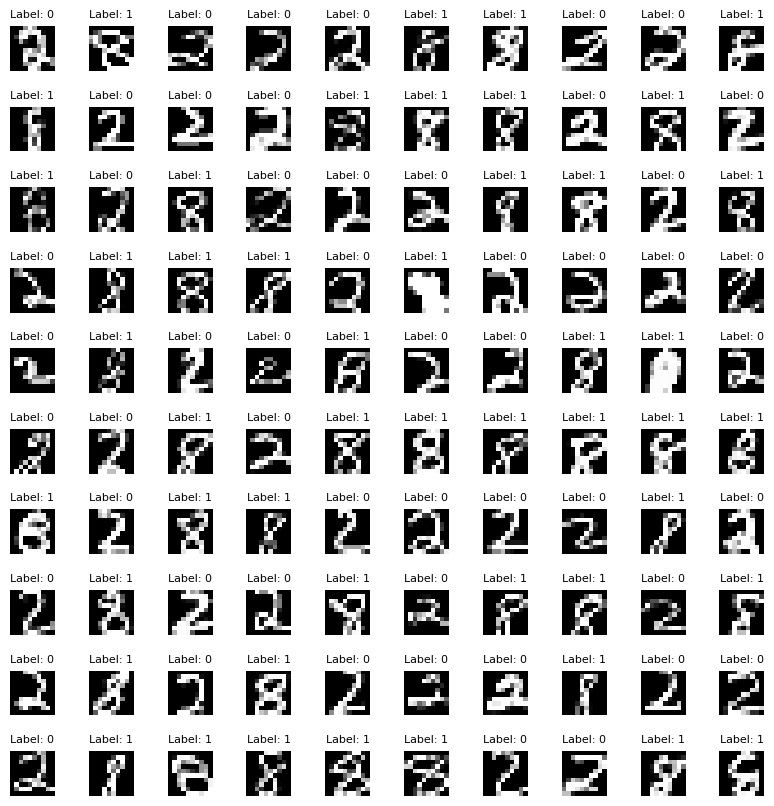

In [186]:
# Matplot is used to render the image 

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.ravel()  # Flatten the 10x10 matrix into an array of 100 subplots

# Loop through subplots and add images
for i in range(100):
    image = test_data[i].reshape(10, 10)  # Assuming the images are 10x10
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {test_labels[i]}", fontsize=8)
    plt.subplots_adjust(hspace=0.8)
    axes[i].axis('off')

plt.show()

<h1>Training the Model </h1>

In [187]:
# Model Before Hyperparameter Tuning
model = RandomForestClassifier(n_estimators=100,max_features='sqrt')
model.fit(training_data, training_labels)

predictions = model.predict(test_data)
print(predictions.shape)

accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100}%')


(1000,)
Accuracy: 97.89999999999999%


In [188]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

model = RandomForestClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)
random_search.fit(training_data, training_labels)

model = random_search.best_estimator_

In [189]:
model.fit(training_data, training_labels)

predictions = model.predict(test_data)
print(predictions.shape)

accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100}%')

(1000,)
Accuracy: 98.1%


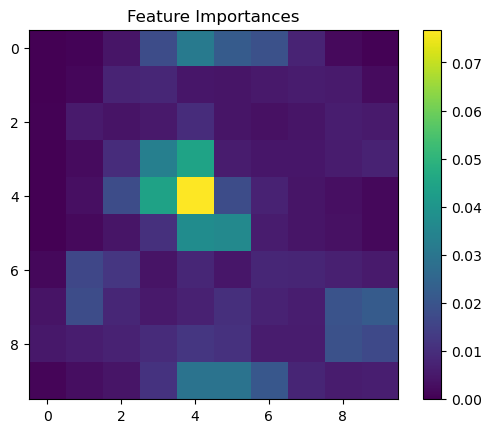

In [190]:
# Feature Importance
importances = model.feature_importances_
importances = importances.reshape(10, 10)  # Assuming MNIST images of size 28x28
plt.imshow(importances, cmap='viridis')
plt.colorbar()
plt.title('Feature Importances')
plt.show()

incorrect predictions: 19


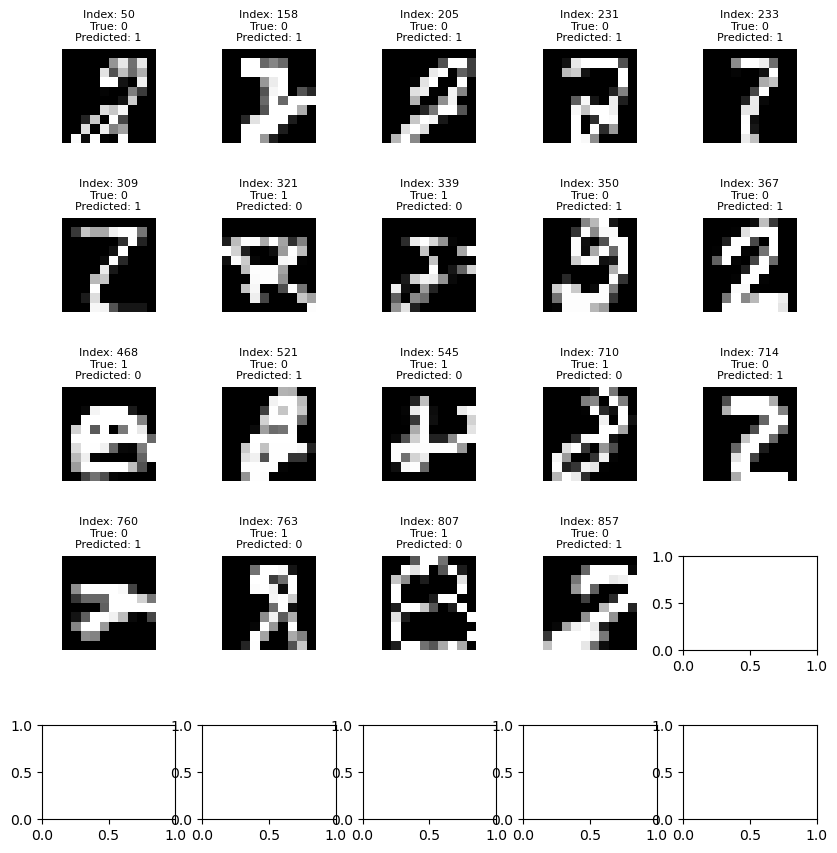

In [191]:
# Sample Correct and Incorrect Predictions
correct_indices = np.where(predictions == test_labels)[0]
incorrect_indices = np.where(predictions != test_labels)[0]
print(f'incorrect predictions: {len(incorrect_indices)}')

sbplts = math.sqrt(len(incorrect_indices))
sbplts = math.ceil(sbplts)

# Display incorrect predicted images
fig, axes = plt.subplots(sbplts, sbplts, figsize=(10, 10))
axes = axes.ravel()  # Flatten the 10x10 matrix into an array of 100 subplots

# Loop through subplots and add images
for i, incorrect_idx in enumerate(incorrect_indices):
    image = test_data[incorrect_idx].reshape(10, 10)  # Assuming the images are 10x10
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Index: {incorrect_idx}\nTrue: {test_labels[incorrect_idx]}\nPredicted: {predictions[incorrect_idx]}", fontsize=8)
    plt.subplots_adjust(hspace=0.8)
    axes[i].axis('off')
plt.show()

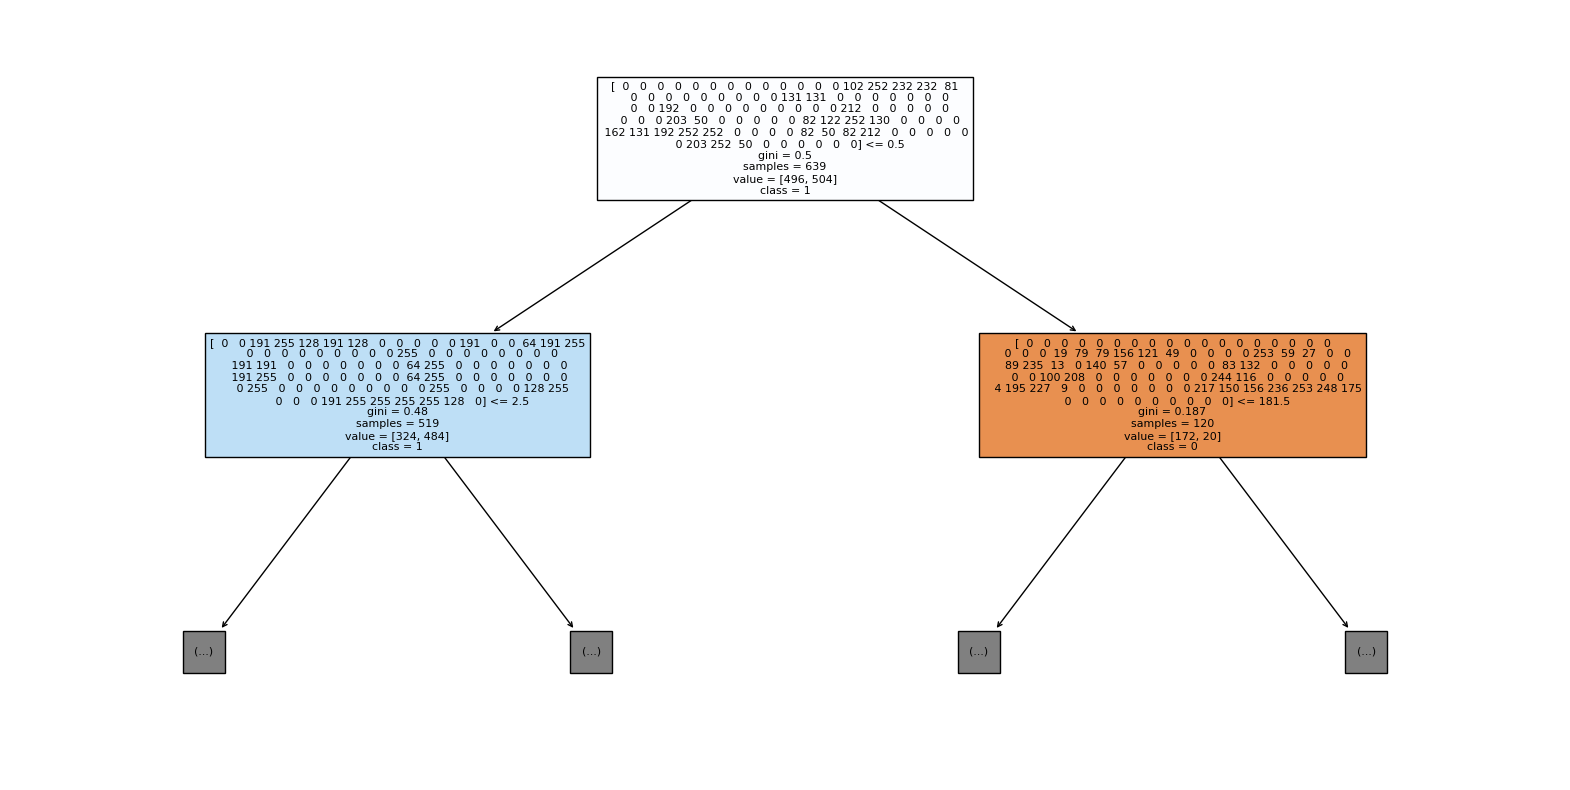

In [192]:
from sklearn.tree import plot_tree

# Plot one tree from the forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True, max_depth=1, feature_names=test_data, class_names=['0', '1'])
plt.show()
